# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

#### Define Hyper parameters for the model

In [2]:
import numpy as np
import random
from collections import namedtuple, deque


import torch
import torch.nn.functional as F
import torch.optim as optim

# replay buffer size
BUFFER_SIZE = int(1e5) 
# mini batch size
BATCH_SIZE = 64  
# discount factor
GAMMA = 0.99  
# target parameters update
TAU = 1e-3   
# learning rate 
LR = 5e-4     
 # update frequency to update the network
UPDATE_FREQUENCY = 4       

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Class for Replay Memory buffer created to store Q value tuples

In [3]:
class ReplayMemory:
    """Buffer memory to store the learning experiences and utilize the in
       learning better"""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

            action_size : action_size
            buffer_size : maximum size
            batch_size :  batch size
            seed : random seed,value generated by random function in python 
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Helps add a new experience values to the memory 
           it appends the values and do not clear the values 
           which helps create a sample of Q value tuples in 
           the memory """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Selecting a random sample of experiences from replay memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """returns size of memory"""
        return len(self.memory)



#### Defining agent actions , switching between different states, learn from sampled data and update the learning curve

In [4]:
class QNAgent():
    """This class will take state and action size as input and help
       the agent interact with environment"""

    def __init__(self, state_size, action_size, seed):
        """Using init to initialize class object for agent.
            state_size : denotes the state size (total states)
            action_size : denotes the action size (total actions that can be taken)
            seed : random seed ,value generated by random function in python 
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        # Setting up of Replay memory to ensure that rewards are accommodated in agent memory dynamically
        self.memory = ReplayMemory(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step value 
        self.time_step = 0
    

        # DQN network initialization
        self.qn_l = DQNetwk(state_size, action_size, seed).to(device)
        self.qn_t = DQNetwk(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qn_l.parameters(), lr=LR)

        
    def step(self, state, action, reward, next_state, done):
        # Adding the Q value params state,action ,reward and next_state in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learning frequency in time steps.
        self.time_step = (self.time_step + 1) % UPDATE_FREQUENCY
        if self.time_step == 0:
            # considering a random subset of experiences from memory for learning of agent
            if len(self.memory) > BATCH_SIZE:
                exp = self.memory.sample()
                self.learn(exp, GAMMA)

    def act(self, state, eps=0.):
        """Defines how an agent can decide on next action and reaches next state as per current policy       
            state : current state
            eps : epsilon value, for selecting the action based epsilon-greedy method
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qn_l.eval()
        with torch.no_grad():
            action_values = self.qn_l(state)
        self.qn_l.train()

        # Selecting the action based epsilon-greedy method
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Capturing q value i.e. a tuple consisting of current state, action , reward and next state

            experiences : tuple of (s, a, r, s') 
            gamma : discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Calculate maximum predicted Q values for next states
        Next_QTarget = self.qn_t(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_target = rewards + (gamma * Next_QTarget * (1 - dones))

        # Fetching expected q value from local model
        Q_expected = self.qn_l(states).gather(1, actions)

        # computing loss value
        loss = F.mse_loss(Q_expected, Q_target)
        # Minimizing the loss value
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update(self.qn_l, self.qn_t, TAU)                     

    def update(self, l_model, t_model, tau):
        """Captures all Updates in model parameters
        θ_target = τ*θ_local + (1 - τ)*θ_target

            l_model : fetching the weights from local model
            t_model : Feeding the weights as input to target model
            tau : interpolation parameter 
        """
        for t_param, l_param in zip(t_model.parameters(), l_model.parameters()):
            t_param.data.copy_(tau*l_param.data + (1.0-tau)*t_param.data)


### Defning the model using standard DQN algorithm

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQNetwk(nn.Module):
    """Fully connected layer model"""

    def __init__(self, state_size, action_size, seed, layer1_nodes=64, layer2_nodes=64):
        """Defining model parameters 
        state_size : state size
        action_size : action size
        seed : random seed,value generated by random function in python 
        layer1_nodes : nodes in first hidden layer
        layer2_noes : nodes in second hidden layer"""
        
        super(DQNetwk, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.l1 = nn.Linear(state_size, layer1_nodes)
        self.l2 = nn.Linear(layer1_nodes, layer2_nodes)
        self.l3 = nn.Linear(layer2_nodes, action_size)

    def forward(self, state):
        """mapping of state to action value pairs and building a neural network"""
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        return self.l3(x)


In [6]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import numpy as np


In [7]:
!pip install unityagents

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [8]:
from unityagents import UnityEnvironment
import numpy as np


# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [9]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [10]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [11]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [12]:
def deep_qn(agent, epsi_start=1.0, epsi_end=0.01, decay_value=0.5, episodes=700, max_time=500,train_flag=True):
    """Deep Q learning algorithm training set 
    
        epsi_start : starting value of epsilon, for selecting action using epsilon-greedy method
        epsi_end : minimum value of epsilon
        decay_value : multiplicative factor for epsilon value
        episodes : maximum number of training episodes
        max_time : maximum number of time steps per episode
        train_flag: flag if set to True will train the agent
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = epsi_start                    # initialize epsilon
    for i in range(1, episodes+1):
        env_info = env.reset(train_mode=train_flag)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_time):
            action = agent.act(state, eps if train_flag else 0.0)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            if train_flag:
                agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        scores_window.append(score)       #  append most recent score to the score list
        scores.append(score)              # save most recent score
        eps = max(epsi_end, decay_value*eps) # decrease epsilon value 
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
        if i % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0 and train_flag:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i-100, np.mean(scores_window)))
            torch.save(agent.qn_l.state_dict(), 'savepoint.pth')
            break
    return scores

In [13]:
agent = QNAgent(state_size=state_size, action_size=action_size, seed=0)
scores = deep_qn(agent)

Episode 100	Average Score: 4.21
Episode 200	Average Score: 6.97
Episode 300	Average Score: 11.92
Episode 367	Average Score: 13.01
Environment solved in 267 episodes!	Average Score: 13.01


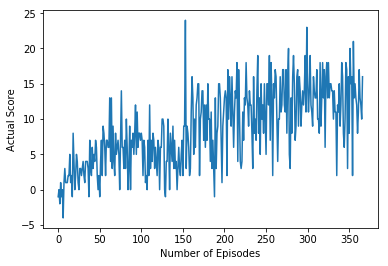

In [14]:
import matplotlib.pyplot as plt
np.random.seed(16)

#plt.scatter(np.arange(len(scores)), scores)
# Draw the line plot
plt.plot(np.arange(len(scores)), scores)

# Define the label of the plots
plt.xlabel('Number of Episodes')
plt.ylabel('Actual Score')

     
# Display the plot
plt.show()

When finished, you can close the environment.

In [15]:
env.close()